In [ ]:
#install packages in jupyter
!pip install rasterio 
!pip install geopandas

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 1.0MB 15.0MB/s 
     |████████████████████████████████| 6.5MB 39.8MB/s 
     |████████████████████████████████| 15.3MB 276kB/s 


In [ ]:
# module imports
import pandas as pd
import numpy as np

# ML imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# geospatial imports
import rasterio as ras
import geopandas as gpd
from osgeo import gdal
from osgeo import ogr

# system imports
import os

# vizualizations
from matplotlib import pyplot as plt

In [ ]:
# required functions
# normalizing the array
def normalize(array):
    """
    normalize an arrary : to prepare to write png
    input: array(any 2D arrray)
    output: noramalized array between 0 -1 
    """
    array_min, array_max = array.min(), array.max()
    return (array - array_min)/(array_max-array_min)

#create an alpha channel
def create_alpha_channel(array_1, array_2, transperent=1.0):
    """
    create a alpha channel for layer transperanacy
    input: array_1 = a known array, array_2 = a known array with same dimentions
    output: nan, 1 value array
    """
    # get shape of array tuple
    arr_shape = array_1.shape
    # create an zero arrya with the above dimentions
    alpha_zero = np.zeros(shape=arr_shape)
    # nan value set to zero
    alpha_zero[alpha_zero== 0.0]= np.nan
    # conditional to assign 1 instead zero
    alpha = np.where((array_1 > 0) & (array_2 > 0), transperent, alpha_zero)
    return alpha


# Model training


In [ ]:
## data set
all_data = pd.read_csv('trainset_allfeatures.csv')
print(all_data.head(10))
#all_data.describe()
all_data.to_csv('cloud_refined.csv', index=False)
all_data.columns

    Map X   Map Y       lat        lon    b1    b2   b3    b4    b5  qc
0  484790  782280  7.077152  80.862269   833   775  462  3088  3038  cd
1  484800  782280  7.077152  80.862360  1007   903  548  3256  3573  cd
2  484810  782280  7.077152  80.862450   971   966  599  3508  3838  cd
3  484820  782280  7.077152  80.862541   689   900  644  3352  3864  cd
4  484780  782280  7.077152  80.862179   783   680  339  2884  2446  cd
5  484780  782270  7.077061  80.862179  1360  1102  635  2856  2320  cd
6  484790  782270  7.077061  80.862269  1488  1244  839  3118  2892  cd
7  484800  782270  7.077061  80.862360  1604  1448  970  3320  3411  cd
8  484810  782270  7.077061  80.862450  1572  1434  999  3378  3669  cd
9  484820  782270  7.077061  80.862541  1214  1136  810  3340  3702  cd


Index(['Map X', 'Map Y', 'lat', 'lon', 'b1', 'b2', 'b3', 'b4', 'b5', 'qc'], dtype='object')

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_data = pd.read_csv('cloud_refined.csv')
main_features = main_data[['lat', 'lon', 'b1', 'b2', 'b3', 'b4', 'b5', 'qc']]

# prediction target
y = main_features.qc

# features( here it is spectrucl features)
X = main_features[['b1', 'b2', 'b3', 'b4', 'b5',]]
X.head()

,b1,b2,b3,b4,b5
0,833,775,462,3088,3038
1,1007,903,548,3256,3573
2,971,966,599,3508,3838
3,689,900,644,3352,3864
4,783,680,339,2884,2446


In [ ]:
# dividing test vaidation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
# model declaration
#cloudModel = DecisionTreeClassifier(random_state=1)
cloudModel = RandomForestClassifier(random_state=1)
# model fit
cloudModel.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
# predictions
train_X.head()

,b1,b2,b3,b4,b5
1519,2454,2742,2662,4432,4816
12756,1288,1898,1886,3166,3943
24383,248,423,259,2940,2992
25107,467,866,568,3514,3373
39297,362,587,531,2462,3301


In [ ]:
# train set prediction
train_predict = cloudModel.predict(train_X.head())
print(train_predict)

# prediction for validating data set
val_redictions = cloudModel.predict(val_X)
#print(mean_absolute_error(val_y, val_redictions))
print(val_redictions)

['cd' 'cd' 'cf' 'cf' 'cf']
['cf' 'cd' 'cd' ... 'cd' 'cf' 'sd']


In [ ]:
# classificatio model accuracy
cm = confusion_matrix(val_y, val_redictions)
print(cm)
acc = accuracy_score(val_y, val_redictions)
print('Accuracy score : {}'.format(acc))

[[5121   19    1]
 [  17 4930    2]
 [  11    2  677]]
Accuracy score : 0.9951762523191094


# *Application of trained model*

In [ ]:
## apply model for a new data set from csv
cand_data = pd.read_csv('Feb27.csv')
cand_data.to_csv('Feb27_refine.csv', index=False)
canddf = pd.read_csv('Feb27_refine.csv')
# source features
cand_X = canddf[['b1','b2','b3','b4','b5']]

# apply model
prdicted_clouds = cloudModel.predict(cand_X)
#print(prdicted_clouds)

# bind predicted qc value to main dataframe
# new df for qc value
cloud_df = pd.DataFrame(columns=['qc'])
# feed data from predicted list
cloud_df['qc'] = prdicted_clouds
# crete qc list
cloud_list = list(cloud_df['qc'])
print(cloud_list[:10])

# predicted qc list attached to image data frame
canddf['qc'] = cloud_list
# write to csv
canddf.to_csv('cloud_id.csv')
canddf.head()

# Automating new image data feed

In [ ]:
#projFolder = './input'
projFolder = './drive/MyDrive/colab_data/input'
imlist = os.listdir(projFolder)

inlist = []
for image in imlist:
  if 'tif' in image:
    inlist.append(image)

print(inlist)

['estate_1_pedro_NE_20200113.tif', 'estate_1_pedro_NE_20200103.tif', 'estate_1_pedro_NE_20200123.tif', 'estate_1_pedro_NE_20200118.tif', 'estate_1_pedro_NE_20200128.tif']


estate_1_pedro_NE_20200113.tif
(232, 189)
estate_1_pedro_NE_20200113
['cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf']


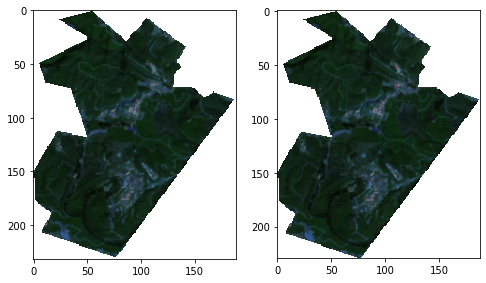

estate_1_pedro_NE_20200103.tif
(232, 189)
estate_1_pedro_NE_20200103
['sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd']


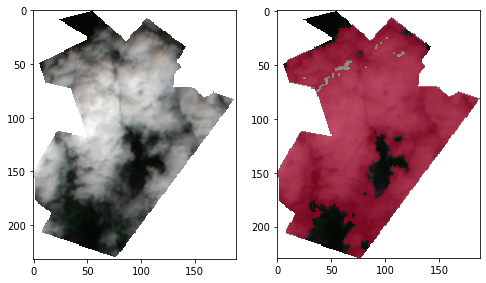

estate_1_pedro_NE_20200123.tif
(232, 189)
estate_1_pedro_NE_20200123
['cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd']


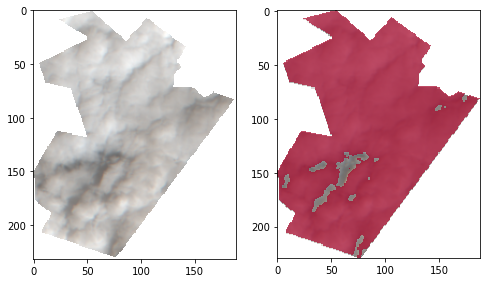

estate_1_pedro_NE_20200118.tif
(232, 189)
estate_1_pedro_NE_20200118
['cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf', 'cf']


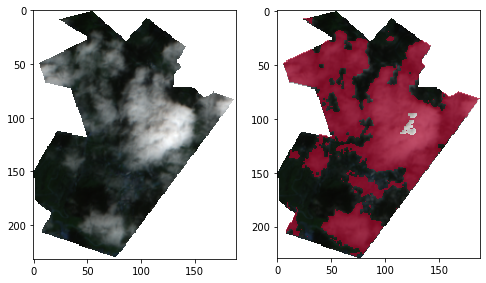

estate_1_pedro_NE_20200128.tif
(232, 189)
estate_1_pedro_NE_20200128
['cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd', 'cd']


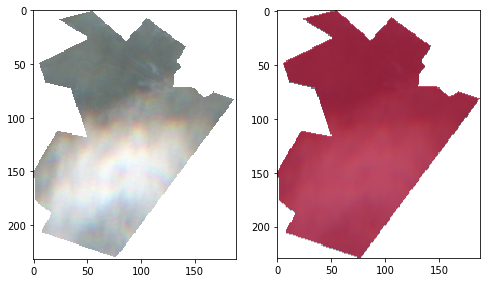

In [ ]:
# Automate extraction of data frame from image
projFolder = './drive/MyDrive/colab_data/input'
imlist = os.listdir(projFolder)

for image in inlist:
    if 'tif' in image:
        print(image)

        rawimage = ras.open(projFolder+'/'+image)
        b11 = rawimage.read(1)
        print(b11.shape)
        # read band arrays to a list(normally the array is list of a list)
        b1 = [item for row in rawimage.read(1).tolist() for item in row] 
        b2 = [item for row in rawimage.read(2).tolist() for item in row]
        b3 = [item for row in rawimage.read(3).tolist() for item in row]
        b4 = [item for row in rawimage.read(4).tolist() for item in row]
        b5 = [item for row in rawimage.read(5).tolist() for item in row]

        # spectrul df
        sepectraldf = pd.DataFrame(columns=[#'lat', 'lon',
                                            'b1', 'b2', 'b3', 'b4', 'b5',
                                        'geometry'])
        # add data to data frame (can be shorten up this part)
        sepectraldf['b1'] = b1
        sepectraldf['b2'] = b2
        sepectraldf['b3'] = b3
        sepectraldf['b4'] = b4
        sepectraldf['b5'] = b5

        #  remove zero reflectance(for dark object or background)::assumes shadow area should reflect small amount of energy
        sepectraldf = sepectraldf[sepectraldf.b1 != 0]
        #print(sepectraldf)

        # extracting central point coordintes from the image
        filename=image[:-4]
        print(filename)
        inDs = gdal.Open('./drive/MyDrive/colab_data/input/{}.tif'.format(filename))
        outDs = gdal.Translate('{}.xyz'.format(filename), inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
        outDs = None
        try:
            os.remove('{}.csv'.format(filename))
        except OSError:
            pass
        os.rename('{}.xyz'.format(filename), '{}.csv'.format(filename))
        os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(filename))


        # erading back the shape with location
        shp = gpd.read_file(image[:-4]+'.shp')
        sepectraldf['geometry'] = shp['geometry']
        #sepectraldf.head()
        # and drawing clouds on the image


        # apply model to the extacted image informations
        # source features
        canddf = sepectraldf
        cand_X = canddf[['b1','b2','b3','b4','b5']]

        # apply model
        prdicted_clouds = cloudModel.predict(cand_X)
        #print(prdicted_clouds)

        # bind predicted qc value to main dataframe
        # new df for qc value
        cloud_df = pd.DataFrame(columns=['qc'])
        # feed data from predicted list
        cloud_df['qc'] = prdicted_clouds
        # crete qc list
        cloud_list = list(cloud_df['qc'])
        print(cloud_list[:10])

        # predicted qc list attached to image data frame
        canddf['qc'] = cloud_list
        # filter only clouded pixels
        #canddf = canddf[canddf.qc=='cd'] #### control output here


        # write to csv
        canddf.to_csv('cloud_id.csv')
        #canddf.head()

        # convet dataframe to geodataframe

        canddf.loc[canddf.qc == "cd", "burn"] = 1
        canddf.loc[canddf.qc == "sd", "burn"] = 0
        canddf.loc[canddf.qc == "cf", "burn"] = 0

        # filter for desired qc
        #canddf = canddf[canddf.qc=='cd']
        # convert to gdf
        candgdf = gpd.GeoDataFrame(canddf, geometry='geometry')
        # value assigning for burn
        candgdf = candgdf[['burn', 'geometry']]

        # declare crs
        candgdf.crs = rawimage.crs
        # save shape file
        candgdf.to_file('toraster.shp', driver='ESRI Shapefile')

        # saving the gdf as a raster
        vector_ds  = ogr.Open('toraster.shp')
        jml_layer = vector_ds.GetLayer()
        jml_file = 'toraster.shp'

        output_raster = 'rasterized_points.tif'
        pixel_size = 10
        xmin, xmax, ymin, ymax = jml_layer.GetExtent()
        ds = gdal.Rasterize(output_raster,jml_file,
                            xRes=pixel_size, yRes=pixel_size, 
                            attribute='burn',outputBounds=[xmin, ymin, xmax, ymax], 
                            outputType=gdal.GDT_Byte)
        ds = None

        #draw image and mask layers
        # open RGB arrays as normalized
        bluen = normalize(rawimage.read(1))
        greenn = normalize(rawimage.read(2))
        redn = normalize(rawimage.read(3))

        # creating alpha band from scrach for layer transperancy
        alpha = create_alpha_channel(redn, bluen)
        # stack bands
        rgb = np.dstack((bluen, greenn, redn, alpha))


        # ML cloud bands open
        cloudData = ras.open('rasterized_points.tif')
        cloudband = cloudData.read(1)
        cloudband = cloudband.astype('float64')
        cloudband[cloudband==0.0] = np.nan

        # fig declaration for 2 axis
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,6))
        # ax 1
        ax1.imshow(rgb)
        # ax2 plots
        plt.imshow(rgb)
        plt.imshow(cloudband,
                #cmap='YlGnBu',
                cmap='RdYlGn', 
                alpha=0.7)
        plt.show()
        plt.close()

        # raster to polygon to draw cloud boundaries
        # remove zeros of images
        # loop over images
